In [37]:
import pandas as pd
import numpy as np
from numpy import mean, std, median
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score,  train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, make_scorer, classification_report, recall_score,r2_score, accuracy_score, cohen_kappa_score, classification_report, confusion_matrix, precision_score,f1_score 
from sklearn.model_selection import cross_validate, cross_val_predict, cross_val_score, KFold, StratifiedKFold 
from imblearn.pipeline import Pipeline 
from imblearn.pipeline import make_pipeline as imbpipeline
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE, ADASYN
import scikitplot as skplt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

In [38]:
#Random seed used in R was 7
random_seed=7

In [39]:
#read input data
#data=pd.read_csv('GS_majority_vote.csv') #all 986 synsets
data=pd.read_csv('GS_All_Agreed.csv') #839 synsets where all annotators agree
#data=pd.read_csv('GS_not_agreed_synsets.csv') #synsets where annotators do not agree

In [40]:
d_tools=pd.DataFrame(data.loc[data['domain_x']=='tool'])
d_fruit=pd.DataFrame(data.loc[data['domain_x']=='fruit'])
d_music=pd.DataFrame(data.loc[data['domain_x']=='music'])
d_furn=pd.DataFrame(data.loc[data['domain_x']=='furn'])
d_garm=pd.DataFrame(data.loc[data['domain_x']=='garm'])

In [41]:
len(d_garm)

241

In [5]:
#list(data)

In [6]:
#set features and target variable 
# 'ngrams_last_mean', 'CHILDES_Sum_Rel','CABNC_per100,000', 'KBNC_Sum','BNC_sum'
features=[ 
 'CHILDES_Sum_Rel',
    'KBNC_Sum',
    'minwordlength_x',
 'nroflemmas_x',
    'polyscore_max_x',
    'nrpartrels_normalised_x',
    'nrhypos_x',
    'glosslength_normalised_x',
    'depthfromtopsynset_normalised_x',
    'nrdirhypers_x',
   ]
target=['vote_x']

In [7]:
#X=np.array(data[features])
#y= np.array(data[target] )
#X=np.array(fmt[features])
#y= np.array(fmt[target] )
#X = np.array(d_music[features])
#y = np.array(d_music[target])
X=np.array(d_tools[features])
y=np.array(d_tools[target])
#X=np.array(d_fruit[features])
#y= np.array(d_fruit[target])
#X=np.array(d_furn[features])
#y= np.array(d_furn[target])
#X=np.array(d_garm[features])
#y= np.array(d_garm[target])

In [8]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_seed)
skf.get_n_splits(X, y)
for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  49  50  51  53  54  55  56  57
  58  59  60  61  63  64  65  66  67  68  69  70  71  73  75  76  77  78
  80  82  83  85  86  87  88  89  90  91  92  93  94  95  96  97  98 100
 101 103 104 106 107 108 109 111 112 113 114 115 116 117 118 119 120 121
 122 123 124 125 126 127 128 129 130 131 132] TEST: [ 13  33  48  52  62  72  74  79  81  84  99 102 105 110]
TRAIN: [  0   1   2   3   4   5   6   7   8   9  11  12  13  14  15  16  17  19
  20  21  22  24  27  28  29  30  32  33  34  36  37  38  39  40  41  42
  43  44  45  46  47  48  49  50  51  52  54  55  56  57  58  59  60  61
  62  63  64  65  66  67  68  69  70  72  73  74  75  76  77  79  81  82
  83  84  85  86  87  88  89  90  91  92  93  94  95  96  98  99 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 118 119 120


In [9]:
#run SMOTE algorithm to deal with class imbalances - make basic class same amount as non-basic
sm = SMOTE(random_state=random_seed, k_neighbors=2)
X_train, y_train = sm.fit_resample(X_train, y_train)
print ('Shape of oversampled data: {}'.format(X_train.shape))
print ('Shape of Y: {}'.format(y_train.shape))

Shape of oversampled data: (196, 10)
Shape of Y: (196,)


In [10]:
#define model and fit oversampled training sets
rf = RandomForestClassifier(random_state=random_seed, max_features='sqrt', n_estimators=500, oob_score=True, criterion='gini', bootstrap=True).fit(X_train, y_train.ravel())

In [11]:
kappa_scorer=make_scorer(cohen_kappa_score)

In [12]:
pipeline=imbpipeline(sm, rf)

In [13]:
kappa=[]

In [14]:
#get cohen kappa scores for 10 fold cross validation
kappa_scores=cross_val_score(pipeline, X, y.ravel(), scoring=kappa_scorer, cv=skf)
kappa.append(kappa_scores)
print(kappa_scores)
print("Mean Kappa score: %0.3f (+/- %0.3f)" % (kappa_scores.mean(), kappa_scores.std()*2))

[0.81081081 0.57575758 0.81081081 1.         0.75471698 1.
 1.         0.62857143 0.56666667 0.75471698]
Mean Kappa score: 0.790 (+/- 0.321)


In [15]:
median=np.median(kappa)
median

0.7827638959714431

In [16]:
df=pd.DataFrame()
df['Tools']=kappa_scores
quart=df['Tools'].describe()
df1=pd.DataFrame(quart).transpose()

In [17]:
df1

,count,mean,std,min,25%,50%,75%,max
Tools,10.0,0.790205,0.169146,0.566667,0.660108,0.782764,0.952703,1.0


In [18]:
y_pred = pipeline.predict(X_test)

In [19]:
#predict test set from cross val splits
cr=(classification_report(y_test,y_pred, output_dict=True))
report=pd.DataFrame(cr).transpose()
report
cr=(classification_report(y_test,y_pred, output_dict=True))
ck=(cohen_kappa_score(y_test, y_pred))
ba=(balanced_accuracy_score(y_test, y_pred))
report=pd.DataFrame(cr).transpose()
report['Cohen Kappa']=ck
report['Balanced Accuracy']=ba

In [20]:
report

,precision,recall,f1-score,support,Cohen Kappa,Balanced Accuracy
b,1.000000,0.666667,0.800000,3.000000,0.754717,0.833333
nb,0.909091,1.000000,0.952381,10.000000,0.754717,0.833333
accuracy,0.923077,0.923077,0.923077,0.923077,0.754717,0.833333
macro avg,0.954545,0.833333,0.876190,13.000000,0.754717,0.833333
weighted avg,0.930070,0.923077,0.917216,13.000000,0.754717,0.833333


Feature: 0, Score: 0.09344
Feature: 1, Score: 0.06779
Feature: 2, Score: 0.06983
Feature: 3, Score: 0.02373
Feature: 4, Score: 0.07695
Feature: 5, Score: 0.01038
Feature: 6, Score: 0.12215
Feature: 7, Score: 0.09749
Feature: 8, Score: 0.42381
Feature: 9, Score: 0.01442


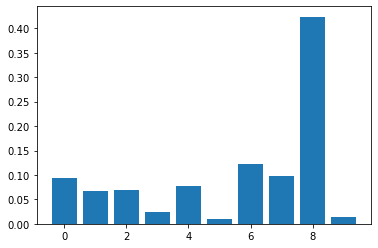

In [21]:
# get feature importance
importance = rf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
fig1=plt.figure()
a=plt.bar([x for x in range(len(importance))], importance)
#plt.savefig('ck/feature_importance_global.png')
plt.show()

In [22]:
imp=[]
for i,v in enumerate(importance):
    imp.append(v)

In [23]:
df4=pd.DataFrame(imp)
df4['Features']=features
df4=df4.rename(columns={0:'Importance'})

In [24]:
df5=df4[['Features', 'Importance']].sort_values('Importance',ascending=False)

In [25]:
df5=df5.rename(columns={'index':'Rank'})

In [26]:
df5

,Features,Importance
8,depthfromtopsynset_normalised_x,0.423814
6,nrhypos_x,0.122155
7,glosslength_normalised_x,0.097494
0,CHILDES_Sum_Rel,0.093439
4,polyscore_max_x,0.076946
2,minwordlength_x,0.069835
1,KBNC_Sum,0.067788
3,nroflemmas_x,0.023726
9,nrdirhypers_x,0.014422
5,nrpartrels_normalised_x,0.010381


In [27]:
df1.to_csv('results/features/combined/cv_ck_kids_tools.csv')

In [28]:
report.to_csv('results/features/combined/CR_kids_tools.csv')

In [29]:
df5.to_csv('results/features/combined/FI_kids_tools.csv')

In [30]:
#_wNG

In [31]:
res=pd.DataFrame(y_pred)

In [32]:
X_test

array([[1.75555880e-17, 1.00000000e-10, 5.00000000e+00, 2.00000000e+00,
        3.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.65823037e+00,
        9.11612903e-01, 1.00000000e+00],
       [1.75555880e-17, 1.00000000e-10, 1.90000000e+01, 1.00000000e+00,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.69310482e-01,
        1.01290323e+00, 1.00000000e+00],
       [1.75555880e-17, 1.00000000e-10, 8.00000000e+00, 2.00000000e+00,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.69908330e-01,
        1.01290323e+00, 1.00000000e+00],
       [1.75555880e-17, 1.00000000e-10, 1.80000000e+01, 1.00000000e+00,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.15763252e+00,
        1.11419355e+00, 1.00000000e+00],
       [1.75555880e-17, 1.00000000e-10, 1.30000000e+01, 2.00000000e+00,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.09505779e+00,
        1.01290323e+00, 1.00000000e+00],
       [1.75555880e-17, 1.00000000e-10, 2.00000000e+01, 1.00000000e+00,
   

In [33]:
X[test_index]

array([[1.75555880e-17, 1.00000000e-10, 5.00000000e+00, 2.00000000e+00,
        3.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.65823037e+00,
        9.11612903e-01, 1.00000000e+00],
       [1.75555880e-17, 1.00000000e-10, 1.90000000e+01, 1.00000000e+00,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.69310482e-01,
        1.01290323e+00, 1.00000000e+00],
       [1.75555880e-17, 1.00000000e-10, 8.00000000e+00, 2.00000000e+00,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.69908330e-01,
        1.01290323e+00, 1.00000000e+00],
       [1.75555880e-17, 1.00000000e-10, 1.80000000e+01, 1.00000000e+00,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.15763252e+00,
        1.11419355e+00, 1.00000000e+00],
       [1.75555880e-17, 1.00000000e-10, 1.30000000e+01, 2.00000000e+00,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.09505779e+00,
        1.01290323e+00, 1.00000000e+00],
       [1.75555880e-17, 1.00000000e-10, 2.00000000e+01, 1.00000000e+00,
   

In [34]:
print(y_pred)

['b' 'nb' 'nb' 'nb' 'nb' 'nb' 'nb' 'nb' 'nb' 'nb' 'nb' 'nb' 'b']


In [35]:
res['Synsets']=y_test

In [36]:
res

,0,Synsets
0,b,b
1,nb,nb
2,nb,nb
3,nb,nb
4,nb,nb
5,nb,nb
6,nb,nb
7,nb,nb
8,nb,nb
9,nb,b


## 